In [1]:
import pathlib
import tempfile

import numpy as np
import seaborn as sns
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds

from tensorflow_datasets.core import SplitGenerator
from tensorflow_datasets.video.bair_robot_pushing import BairRobotPushingSmall

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
TEST_DIR = pathlib.Path(tempfile.mkdtemp())

In [3]:
!mkdir -p $TEST_DIR
!wget -nv https://storage.googleapis.com/download.tensorflow.org/data/bair_test_traj_0_to_255.tfrecords -O $TEST_DIR/traj_0_to_255.tfrecords

2020-07-14 07:41:42 URL:https://storage.googleapis.com/download.tensorflow.org/data/bair_test_traj_0_to_255.tfrecords [189852160/189852160] -> "/tmp/tmpb7l_u4fn/traj_0_to_255.tfrecords" [1]


In [4]:
# Since the dataset builder expects the train and test split to be downloaded,
# patch it so it only expects the test data to be available
builder = BairRobotPushingSmall()
test_generator = SplitGenerator(name = 'test', gen_kwargs = {"filedir": str(TEST_DIR)})
builder._split_generators = lambda _: [test_generator]
builder.download_and_prepare()

Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`


Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`


Shuffling and writing examples to /root/tensorflow_datasets/bair_robot_pushing_small/2.0.0.incompleteUQ25B0/bair_robot_pushing_small-test.tfrecord


Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.map_fn(fn, elems, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.map_fn(fn, elems))


Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.map_fn(fn, elems, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.map_fn(fn, elems))



Dataset bair_robot_pushing_small downloaded and prepared to /root/tensorflow_datasets/bair_robot_pushing_small/2.0.0. Subsequent calls will reuse this data.


### BAIR: Demo based on numpy array inputs

In [5]:
batch_size = 16

# If unable to download the dataset automatically due to "not enough disk space", please download manually to Google Drive and
# load using tf.data.TFRecordDataset.
ds = builder.as_dataset(split = "test")
test_videos = ds.batch(batch_size)
first_batch = next(iter(test_videos))
input_frames = first_batch['image_aux1'][:, ::15]
input_frames = tf.cast(input_frames, tf.float32)

Test videos shape [batch_size, start/end frame, height, width, num_channels]:  (16, 2, 64, 64, 3)


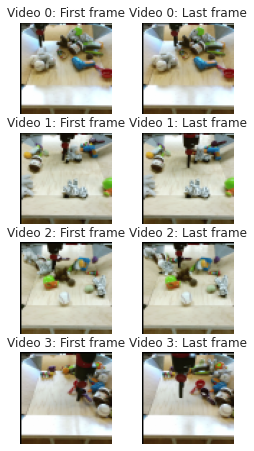

In [6]:
print('Test videos shape [batch_size, start/end frame, height, width, num_channels]: ', input_frames.shape)
sns.set_style('white')
plt.figure(figsize = (4, 2*batch_size))

for i in range(batch_size)[:4]:
  plt.subplot(batch_size, 2, 1 + 2*i)
  plt.imshow(input_frames[i, 0] / 255.0)
  plt.title('Video {}: First frame'.format(i))
  plt.axis('off')
  plt.subplot(batch_size, 2, 2 + 2*i)
  plt.imshow(input_frames[i, 1] / 255.0)
  plt.title('Video {}: Last frame'.format(i))
  plt.axis('off')

### Load Hub Module

In [7]:
hub_handle = 'https://tfhub.dev/google/tweening_conv3d_bair/1'
module = hub.load(hub_handle).signatures['default']

### Generate and show the videos

In [8]:
filled_frames = module(input_frames)['default'] / 255.0

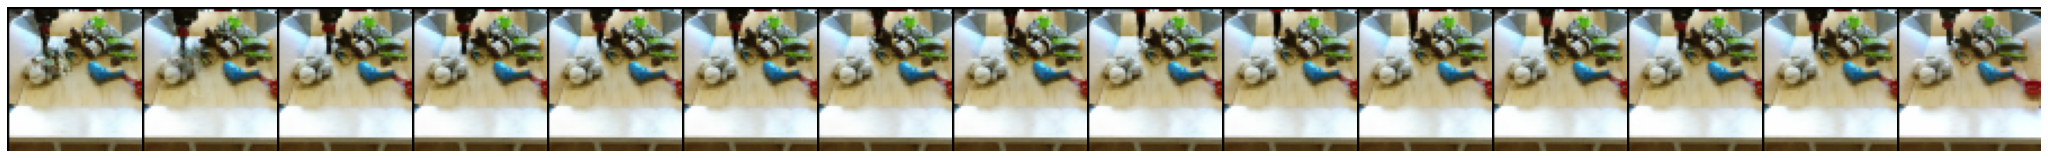

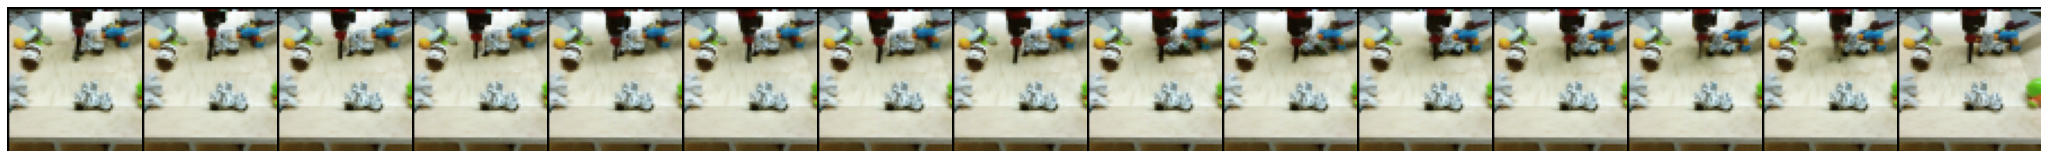

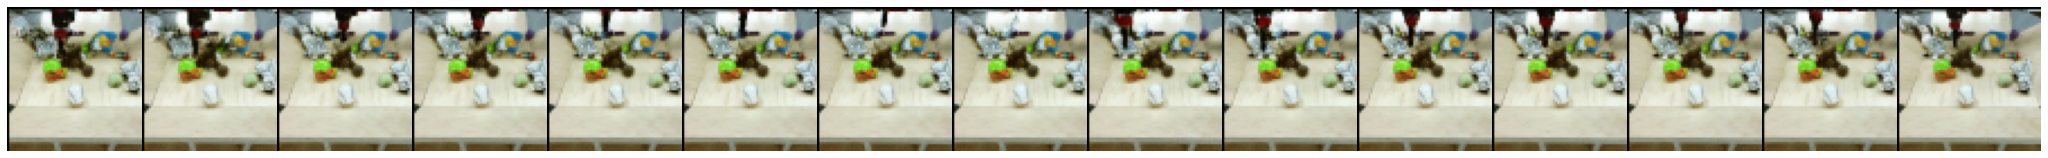

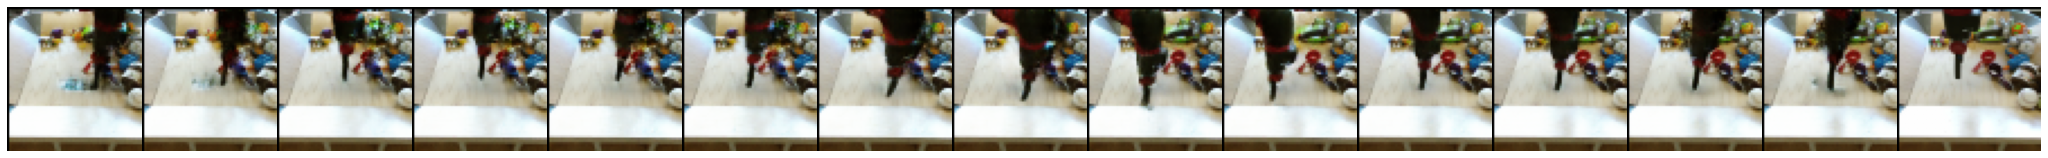

In [9]:
# Show sequences of generated video frames.

# Concatenate start/end frames and the generated filled frames for the new videos.
generated_videos = np.concatenate([input_frames[:, :1] / 255.0, filled_frames, input_frames[:, 1:] / 255.0], axis = 1)

for video_id in range(4):
  fig = plt.figure(figsize = (10 * 2, 2))
  for frame_id in range(1, 16):
    ax = fig.add_axes([frame_id * 1 / 16., 0, (frame_id + 1) * 1 / 16., 1],
                      xmargin = 0, ymargin = 0)
    ax.imshow(generated_videos[video_id, frame_id])
    ax.axis('off')